# Classification With Support Vector Machines

## Problems
Total points: 100
The UC Irvine machine learning data repository hosts a collection of data on adult income, donated by Ronny Kohavi and Barry Becker. You can find this data at https://archive.ics.uci.edu/ml/datasets/Adult For each record, there is a set of continuous attributes, and a class "less than 50K" or "greater than 50K". We have pre-split the data training with 43957 examples with known class labels, and testing data with 4885 examples without class labels. Use this data, not the original, for this assignment.

Write a program to train a support vector machine on this data using stochastic gradient descent, as detailed in Procedure 4.3 from the text.

(Update 2/2) As several people pointed out, the gradient formula provided during AML lecture was incorrect.  The correct formulas can be found in the text under the heading "Setting up stochastic gradient descent".  Specifically, the correct gradients are:



You should not use a package to train the classifier (that's the point), but your own code. You should ignore the id number, and use only the continuous variables as a feature vector. You should scale these variables so that each has unit variance, and you should subtract the mean so that each has zero mean. You should search for an appropriate value of the regularization constant, trying at least the values [1e-3, 1e-2, 1e-1, 1]. Use 10% of your training data as a validation set for this search. You should use at least 50 epochs seasons of at least 300 steps each. In each epoch season, you should separate out 50 training examples at random for evaluation (call this the set held out for the epoch season). You should compute the accuracy of the current classifier on the validation set for the epoch season every 30 steps.

You should produce:

- A plot of the validation accuracy every 30 steps, for each value of the regularization constant.
- A plot of the magnitude of the coefficient vector every 30 steps, for each value of the regularization constant.
- Your estimate of the best value of the regularization constant, together with a brief description of why you believe that is a good value.
- Answer the question: What was your choice for the learning rate and why did you choose it?
- Once you have trained your final classifier, score the provided test set, recording the results in a file with the same format as submission.txt.  You will be able to submit this result to gradescope repeatedly for scoring.

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
import numpy as np
import matplotlib.pyplot as plt

# Zero mean unit variance
def zmuv(a):
  a = (a-a.mean(axis=0))/a.std(axis=0)
  return a

# Import training data (f for features, l for labels)
train_f = np.genfromtxt('drive/My Drive/CS 498 AML/HW2/Data/train.txt', dtype=None, delimiter=",", usecols=(0,2,4,10,11,12))
train_l = np.genfromtxt('drive/My Drive/CS 498 AML/HW2/Data/train.txt', dtype=np.string_, delimiter=",", usecols=(14))

train_l[train_l==b' <=50K'] = -1
train_l[train_l==b' >50K'] = 1
train_l = np.asarray([train_l], dtype=int)
train_f = zmuv(train_f)

# Make a single array of standardized features and corresponding labels
train = np.concatenate([train_f,train_l.T],axis=1)

# Import test data (f for features, l for labels)
test_f = np.genfromtxt('drive/My Drive/CS 498 AML/HW2/Data/test.txt', dtype=None, delimiter=",", usecols=(0,2,4,10,11,12))
test_f = zmuv(test_f)

# Pick 10% of all training data for lambda validation set
# Pick 50 samples from training data for eta validation set
# Pick 1 sample from the remaining training data for learning
# ind is 10% of all training data

def reshuffle():
  ind = 4396

  shuffled = train.copy()
  np.random.shuffle(shuffled)

  lam_val = shuffled[0:ind,:]
  lam_val_f = lam_val[:,0:6]
  lam_val_l = np.array([lam_val[:,6]]).T

  eta_val = shuffled[ind:ind+50,:]
  eta_val_f = eta_val[:,0:6]
  eta_val_l = np.array([eta_val[:,6]]).T

  training_sample = shuffled[ind+50,:]
  training_sample_f = np.array([training_sample[0:6]])
  training_sample_l = np.array([[training_sample[6]]])
  return None

In [0]:
# xi is a column vector of features
# yi is a label
# a is a column vector
# b is a scalar

# Predict and return sign
def predict(u, x):
  s = np.dot(u[0].T,x.T)+u[1]
  s = np.sign(s)
  return s.T

# Compare real and predicted labels and get accuracy
def accuracy(u, x, y):
  s = predict(u, x)
  acc = np.sum(y == s)/y.size
  return acc

# Calculate gradient of u. Return gradient w.r.t. to a and b
def gradient(yi, xi, u, lam=1e-3):
  crit = yi[0,0]*gamma(u, xi)
  if crit >= 1:
    grad_b = 0
    grad_a = lam * u[0]
  else:
    grad_b = -yi[0,0]
    grad_a = lam * u[0] - yi[0,0]*xi
  return [grad_a,grad_b]

# Taking a step with eta and gradient. Return new value of u
def step(u, grad, k):
  a_new = u[0] - eta(k)*grad[0]
  b_new = u[1] - eta(k)*grad[1]
  return [a_new, b_new]

# Calculate gamma
def gamma(u, xi):
  gam = np.dot(u[0].T,xi) + u[1]
  return gam

# Returns training cost
def training_cost(u, yi, xi, gam, lam=1e-3):
  cost = (1/len(yi))*np.amax([0,1-np.dot(yi,gamma(u, xi))])+(lam/2)*np.dot(u[0].T,u[0])
  return cost

# Calculate eta based on season#
def eta(k, m=1, n=50):
  return m/(k+n)

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


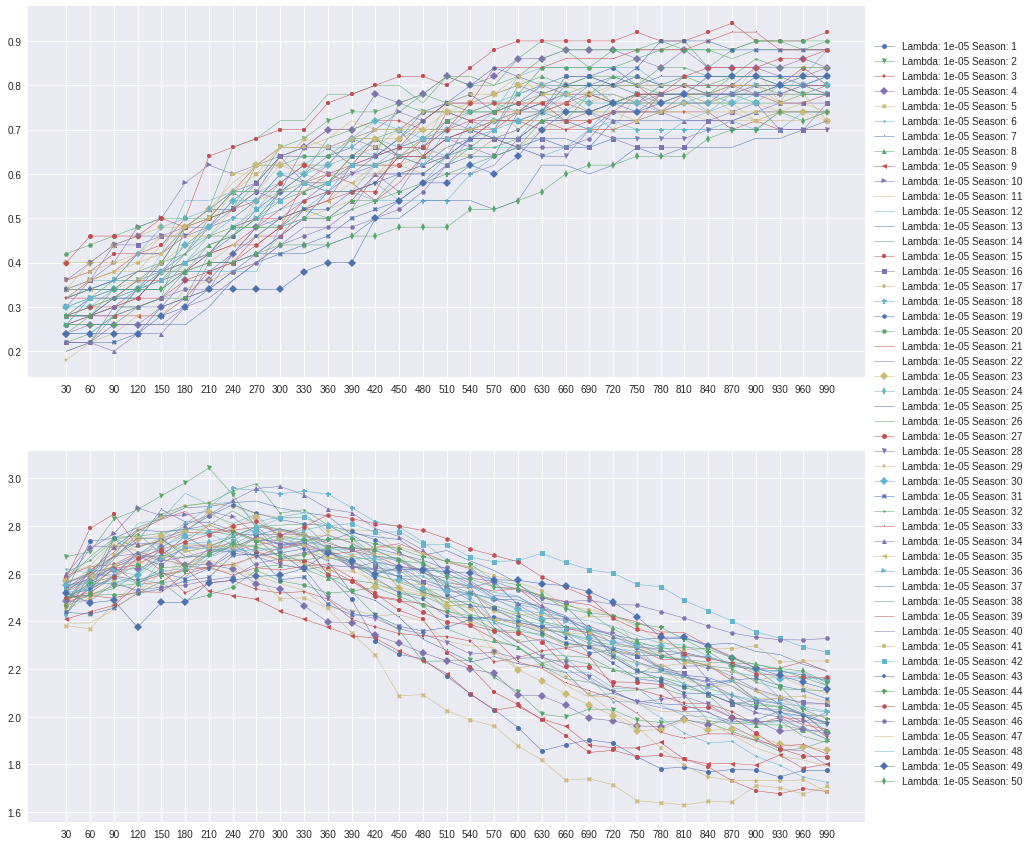

max sum in >>>> Lambda: 1e-05 Season: 15 
a, b =  [array([[0.31804914],
       [0.14026951],
       [0.53318245],
       [1.52159757],
       [0.22748698],
       [0.26621688]])
 -0.90625]
max half sum in >>>> Lambda: 1e-05 Season: 15 
a, b =  [array([[0.31804914],
       [0.14026951],
       [0.53318245],
       [1.52159757],
       [0.22748698],
       [0.26621688]])
 -0.90625]
max single last step in >>>>  Lambda: 1e-05 Season: 15 at:  0.92 
a, b =  [array([[0.31804914],
       [0.14026951],
       [0.53318245],
       [1.52159757],
       [0.22748698],
       [0.26621688]])
 -0.90625]


In [11]:
# Prepare data based on size of lambda validation set of 4396 (10%)
ind = 4396

shuffled = train.copy()
np.random.shuffle(shuffled)

lam_val = shuffled[0:ind,:]
lam_val_f = lam_val[:,0:6]
lam_val_l = np.array([lam_val[:,6]]).T

training_lesslam = shuffled[ind:,:]

# SVM Setup
num_step = 990
season = 50
lam = np.array([1e-5])

label = list()
step_acc_list = list()
acc_list = list()
new_ab_list = list()
markers=['o','v','*','D','X','.',',','^','<','>','1','2','3','4','8','s','p','P','h','H','+','x','D','d','|','_','o','v','*','D','X','.',',','^','<','>','1','2','3','4','8','s','p','P','h','H','+','x','D','d','|','_']
plt.figure(figsize=(15,15))

# Loop thorugh all lambdas
for j in range(len(lam)):
#   Loop through all seasons
  for k in range(season): 
#     Shuffle to get new validation sets and new training data
    foreta = training_lesslam.copy()
    np.random.shuffle(foreta)
    
    eta_val = foreta[0:50,:]
    eta_val_f = eta_val[:,0:6]
    eta_val_l = np.array([eta_val[:,6]]).T
    
#     Reinitialize a and b
    a = np.full((6,1),1)
    b = 4
    u = [a,b]
    new_ab = u.copy()
#     Reinitialize accuracy matrix
    acc = np.zeros((1,int(num_step/30)))
    step_acc = np.array([np.arange(0,num_step,30)])+30
    mag_a = np.zeros((1,int(num_step/30)))    
    
#     Loop through all steps
    for i in range(num_step):
      rand = int(np.random.randint(foreta.shape[0]-50))
      training_sample = foreta[rand+50,:]
      training_sample_f = np.array([training_sample[0:6]])
      training_sample_l = np.array([[training_sample[6]]])

      xi = training_sample_f.T
      yi = training_sample_l
      grad = gradient(yi, xi, new_ab)
      new_ab = step(new_ab, grad, k)
#       Calculate accuracy every 30 steps
      if (1+i)%30 == 0:
        m = int((1+i)/30)
        acc[0,m-1] = accuracy(new_ab, eta_val_f, eta_val_l)
        mag_a[0,m-1] = np.linalg.norm(new_ab[0])
    
    
#     print("\nLambda: ",lam[j],"Season#: ",k+1, "=", acc)
#     print("New U:\n",new_ab)

    acc_list.append((acc[0]))
    step_acc_list.append('Lambda: %s Season: %s' %(lam[j], k+1))
    new_ab_list.append(new_ab[:])

    plt.subplot(211) 
    label.append(plt.plot(step_acc[0],acc[0],linewidth=0.5, label = 'Lambda: %s Season: %s' %(lam[j], k+1), marker = markers[j+k+j+j+j],  markersize=5))
    plt.xticks(np.arange(min(step_acc[0]), max(step_acc[0])+1, 30))

    plt.subplot(212) 
    label.append(plt.plot(step_acc[0],mag_a[0],linewidth=0.5, label = 'Lambda: %s Season: %s' %(lam[j], k+1), marker = markers[j+k+j+j+j],  markersize=5))
    plt.xticks(np.arange(min(step_acc[0]), max(step_acc[0])+1, 30))
    
plt.legend(label)
plt.legend(loc='center left', bbox_to_anchor=(1, 1.1))
plt.show()

acc_list = np.array(acc_list)
step_acc_list = np.array(step_acc_list)
new_ab_list = np.array(new_ab_list)

print("max sum in >>>>", step_acc_list[sum(acc_list.T).argmax()] , "\na, b = ", new_ab_list[sum(acc_list.T[:]).argmax()])
print("max half sum in >>>>", step_acc_list[sum(acc_list.T[7:]).argmax()], "\na, b = ", new_ab_list[sum(acc_list.T[7:]).argmax()])
print("max single last step in >>>> ", step_acc_list[(acc_list.T[-1]).argmax()], "at: ",max(acc_list.T[-1]), "\na, b = ", new_ab_list[np.unravel_index((acc_list).argmax(),acc_list.shape)[0]])

In [0]:
# xi is a column vector of features
# yi is a label
# a is a column vector
# b is a scalar

# Predict and return sign
def predict(u, x):
  s = np.dot(u[0].T,x.T)+u[1]
  s = np.sign(s)
  return s.T

# Compare real and predicted labels and get accuracy
def accuracy(u, x, y):
  s = predict(u, x)
  acc = np.sum(y == s)/y.size
  return acc

# Calculate gradient of u. Return gradient w.r.t. to a and b
def gradient(yi, xi, u, lam=1e-3):
  crit = yi[0,0]*gamma(u, xi)
  if crit >= 1:
    grad_b = 0
    grad_a = lam * u[0]
  else:
    grad_b = -yi[0,0]
    grad_a = lam * u[0] - yi[0,0]*xi
  return [grad_a,grad_b]

# Taking a step with eta and gradient. Return new value of u
def step(u, grad, k):
  a_new = u[0] - eta(k)*grad[0]
  b_new = u[1] - eta(k)*grad[1]
  return [a_new, b_new]

# Calculate gamma
def gamma(u, xi):
  gam = np.dot(u[0].T,xi) + u[1]
  return gam

# Returns training cost
def training_cost(u, yi, xi, gam, lam=1e-3):
  cost = (1/len(yi))*np.amax([0,1-np.dot(yi,gamma(u, xi))])+(lam/2)*np.dot(u[0].T,u[0])
  return cost

# Calculate eta based on season#
def eta(k, m=1, n=50):
  return 1/64 #m/(2*k+n)

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


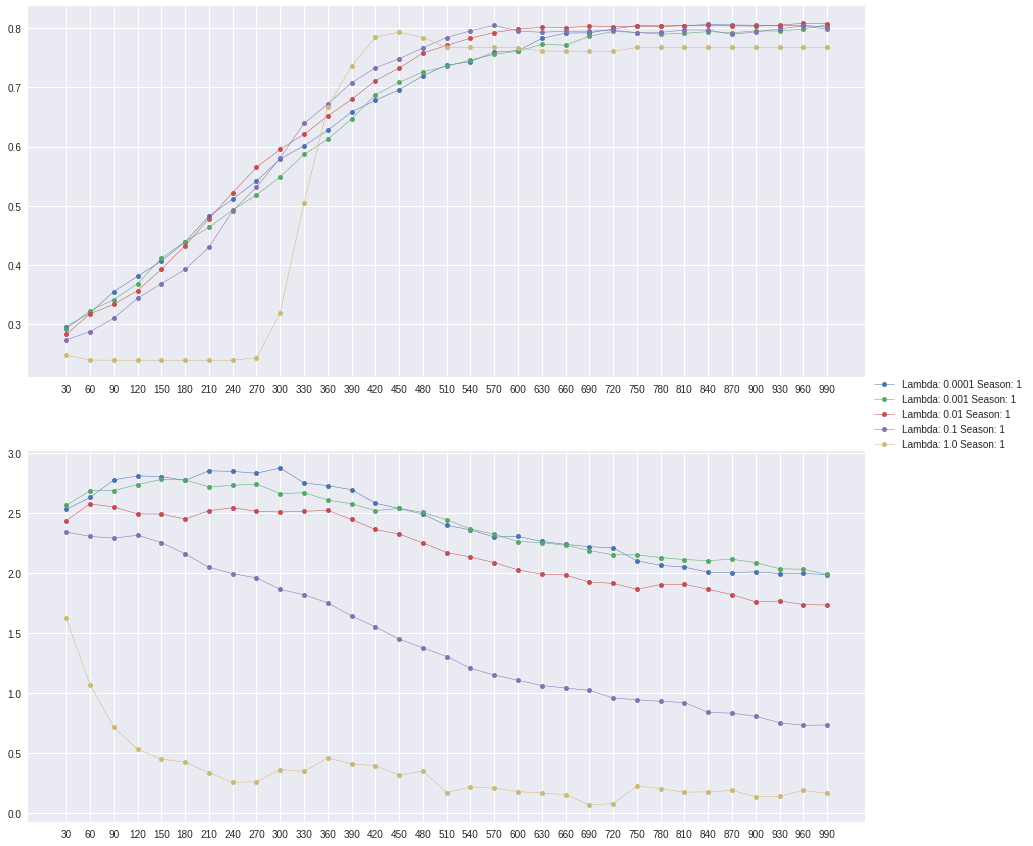

max sum in >>>> Lambda: 0.01 Season: 1 
a, b =  [array([[0.37460604],
       [0.1551405 ],
       [0.55226118],
       [1.46628975],
       [0.498473  ],
       [0.37187249]])
 -0.953125]
max half sum in >>>> Lambda: 0.01 Season: 1 
a, b =  [array([[0.37460604],
       [0.1551405 ],
       [0.55226118],
       [1.46628975],
       [0.498473  ],
       [0.37187249]])
 -0.953125]
max single last step in >>>>  Lambda: 0.01 Season: 1 at:  0.8080072793448589 
a, b =  [array([[0.37460604],
       [0.1551405 ],
       [0.55226118],
       [1.46628975],
       [0.498473  ],
       [0.37187249]])
 -0.953125]


In [17]:
# Prepare data based on size of lambda validation set of 4396 (10%)
ind = 4396

shuffled = train.copy()
np.random.shuffle(shuffled)

lam_val = shuffled[0:ind,:]
lam_val_f = lam_val[:,0:6]
lam_val_l = np.array([lam_val[:,6]]).T

training_lesslam = shuffled[ind:,:]

# SVM Setup
num_step = 990
season = 1
lam = np.array([1e-4, 1e-3, 1e-2, 1e-1, 1])

label = list()
label2 = list()

step_acc_list = list()
acc_list = list()
new_ab_list = list()
markers=['o','v','*','D','X','.',',','^','<','>','1','2','3','4','8','s','p','P','h','H','+','x','D','d','|','_']
plt.figure(figsize=(15,15))

# Loop thorugh all lambdas
for j in range(len(lam)):
#   Loop through all seasons
  for k in range(season): 
#     Shuffle to get new validation sets and new training data
    foreta = training_lesslam.copy()
    np.random.shuffle(foreta)
    
    eta_val = foreta[0:50,:]
    eta_val_f = eta_val[:,0:6]
    eta_val_l = np.array([eta_val[:,6]]).T
    
#     Reinitialize a and b
    a = np.full((6,1),1)
    b = 4
    u = [a,b]
    new_ab = u.copy()
#     Reinitialize accuracy matrix
    acc = np.zeros((1,int(num_step/30)))
    mag_a = np.zeros((1,int(num_step/30)))    
    step_acc = np.array([np.arange(0,num_step,30)])+30
#     Loop through all steps
    for i in range(num_step):
      rand = int(np.random.randint(foreta.shape[0]-50))
      training_sample = foreta[rand+50,:]
      training_sample_f = np.array([training_sample[0:6]])
      training_sample_l = np.array([[training_sample[6]]])

      xi = training_sample_f.T
      yi = training_sample_l
      grad = gradient(yi, xi, new_ab,lam[j])
      new_ab = step(new_ab, grad, k)
#       Calculate accuracy every 30 steps
      if (1+i)%30 == 0:
        m = int((1+i)/30)
        acc[0,m-1] = accuracy(new_ab, lam_val_f, lam_val_l)
        mag_a[0,m-1] = np.linalg.norm(new_ab[0])
    
#     print("\nLambda: ",lam[j],"Season#: ",k+1, "=", acc)
#     print("New U:\n",new_ab)

    acc_list.append((acc[0]))
    step_acc_list.append('Lambda: %s Season: %s' %(lam[j], k+1))
    new_ab_list.append(new_ab[:])
    
    plt.subplot(211) 
    label.append(plt.plot(step_acc[0],acc[0],linewidth=0.5, label = 'Lambda: %s Season: %s' %(lam[j], k+1), marker = markers[k],  markersize=5))
    plt.xticks(np.arange(min(step_acc[0]), max(step_acc[0])+1, 30))

    plt.subplot(212) 
    label.append(plt.plot(step_acc[0],mag_a[0],linewidth=0.5, label = 'Lambda: %s Season: %s' %(lam[j], k+1), marker = markers[k],  markersize=5))
    plt.xticks(np.arange(min(step_acc[0]), max(step_acc[0])+1, 30))

plt.legend(label)
plt.legend(loc='center left', bbox_to_anchor=(1, 1.1))
plt.show()

acc_list = np.array(acc_list)
step_acc_list = np.array(step_acc_list)
new_ab_list = np.array(new_ab_list)

print("max sum in >>>>", step_acc_list[sum(acc_list.T).argmax()] , "\na, b = ", new_ab_list[sum(acc_list.T[:]).argmax()])
print("max half sum in >>>>", step_acc_list[sum(acc_list.T[7:]).argmax()], "\na, b = ", new_ab_list[sum(acc_list.T[7:]).argmax()])
print("max single last step in >>>> ", step_acc_list[(acc_list.T[-1]).argmax()], "at: ",max(acc_list.T[-1]), "\na, b = ", new_ab_list[np.unravel_index((acc_list).argmax(),acc_list.shape)[0]])

In [0]:
a1 = np.array([0.37460604,\
       0.1551405 ,\
       0.55226118,\
       1.46628975,\
       0.498473  ,\
       0.37187249])
b1 = -0.953125

u1 = np.array((a1,b1))
pre = predict(u1, test_f)
pretxt = ""
for i in range(pre.size):
  if pre[i]==-1:
    pretxt=pretxt+'<=50K\n'
  else:
    pretxt=pretxt+'>50K\n'
f = open('drive/My Drive/CS 498 AML/HW2/submission6.txt', 'w')
f.write(pretxt)
f.close()